In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path

import jax
import numpyro
from hbmep.config import Config
from hbmep.model import Model

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)
logger = logging.getLogger(__name__)


#### Initialize config and model

In [2]:
# Path to toml file
root_path = Path(os.getcwd()).parent.absolute()
toml_path = os.path.join(root_path, "config.toml")
logger.info(f"Toml path - {toml_path}")

2023-07-31 11:24:38,873 - __main__ - INFO - Toml path - /home/vishu/hbmep/config.toml


In [3]:
# Initialize config and validate
config = Config(toml_path=toml_path)

# Initialize model
model = Model(config=config)

2023-07-31 11:24:38,919 - hbmep.config - INFO - Verifying configuration ...
2023-07-31 11:24:38,919 - hbmep.config - INFO - Success!
2023-07-31 11:24:38,932 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link


#### Load data and preprocess

In [4]:
# Preprocess data
df, encoder_dict = model.load()


2023-07-31 11:24:39,013 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/hbmep/reports/mock_test
2023-07-31 11:24:39,014 - hbmep.dataset.core - INFO - Copied config to /home/vishu/hbmep/reports/mock_test
2023-07-31 11:24:39,015 - hbmep.dataset.core - INFO - Reading data from /home/vishu/data/mock/mock.csv ...
2023-07-31 11:24:39,020 - hbmep.dataset.core - INFO - Processing data ...
2023-07-31 11:24:39,021 - hbmep.utils.utils - INFO - func:load took: 0.01 sec


#### Visualize dataset

In [5]:
model.plot(df=df, encoder_dict=encoder_dict)


2023-07-31 11:24:39,164 - hbmep.dataset.core - INFO - Plotting dataset ...


2023-07-31 11:24:40,582 - hbmep.dataset.core - INFO - Saved to /home/vishu/hbmep/reports/mock_test/dataset.pdf
2023-07-31 11:24:40,583 - hbmep.utils.utils - INFO - func:plot took: 1.42 sec


Prior predictive check: We can draw from the model to see if it correctly specifies our prior knowledge

In [6]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict)


2023-07-31 11:24:40,666 - hbmep.model.baseline - INFO - Generating predictions ...


2023-07-31 11:24:42,863 - hbmep.utils.utils - INFO - func:predict took: 2.19 sec
2023-07-31 11:24:42,865 - hbmep.model.baseline - INFO - Rendering Prior Predictive Check ...
2023-07-31 11:24:44,368 - hbmep.model.baseline - INFO - Saved to /home/vishu/hbmep/reports/mock_test/prior_predictive_check.pdf
2023-07-31 11:24:44,368 - hbmep.utils.utils - INFO - func:render_predictive_check took: 3.70 sec


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-07-31 11:24:44,421 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary(prob=.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0]      6.01      0.10      6.01      5.82      6.21  19746.16      1.00
  H[0,0,1]      3.78      0.06      3.78      3.67      3.89  30674.46      1.00
  H[0,1,0]      2.86      3.26      1.77      0.00      9.37  16558.84      1.00
  H[0,1,1]      1.23      1.64      0.71      0.00      4.18  15102.74      1.00
  H[1,0,0]      4.28      0.19      4.27      3.92      4.67  14626.73      1.00
  H[1,0,1]      1.49      0.03      1.49      1.42      1.56  21989.13      1.00
  H[1,1,0]      2.85      3.28      1.75      0.00      9.31  17274.62      1.00
  H[1,1,1]      1.23      1.65      0.70      0.00      4.19  15516.74      1.00
  H[2,0,0]      4.55      4.09      3.48      0.00     12.36  23480.17      1.00
  H[2,0,1]      3.23      3.10      2.35      0.00      9.31  21911.08      1.00
  H[2,1,0]      0.35      0.02      0.34      0.31      0.38  14834.71      1.00
  H[2,1,1]      0.56      0

#### Plot recruitment curves

In [ ]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-07-31 11:11:38,178 - hbmep.model.baseline - INFO - Generating predictions ...
2023-07-31 11:11:45,072 - hbmep.utils.utils - INFO - func:predict took: 6.89 sec
2023-07-31 11:11:45,100 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-07-31 11:11:48,086 - hbmep.model.baseline - INFO - Saved to /home/vishu/hbmep/reports/mock_test/recruitment_curves.pdf
2023-07-31 11:11:48,086 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 9.91 sec


#### Posterior Predictive Check

We can now supply the posterior samples to `render_predictive_check` method to inspect how well our model is able to explain the data

2023-07-31 11:23:08,585 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
Traceback (most recent call last):
  File "/home/vishu/hbmep/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_607362/3790972742.py", line 1, in <module>
    model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)
  File "/home/vishu/hbmep/src/hbmep/model/core.py", line 59, in render_predictive_check
    self.model.render_predictive_check(
  File "/home/vishu/hbmep/src/hbmep/utils/utils.py", line 15, in wrap
    result = f(*args, **kw)
             ^^^^^^^^^^^^^^
  File "/home/vishu/hbmep/src/hbmep/model/baseline.py", line 485, in render_predictive_check
AttributeError: 'RectifiedLogistic' object has no attribute '_predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 

Unexpected exception formatting exception. Falling back to standard exception


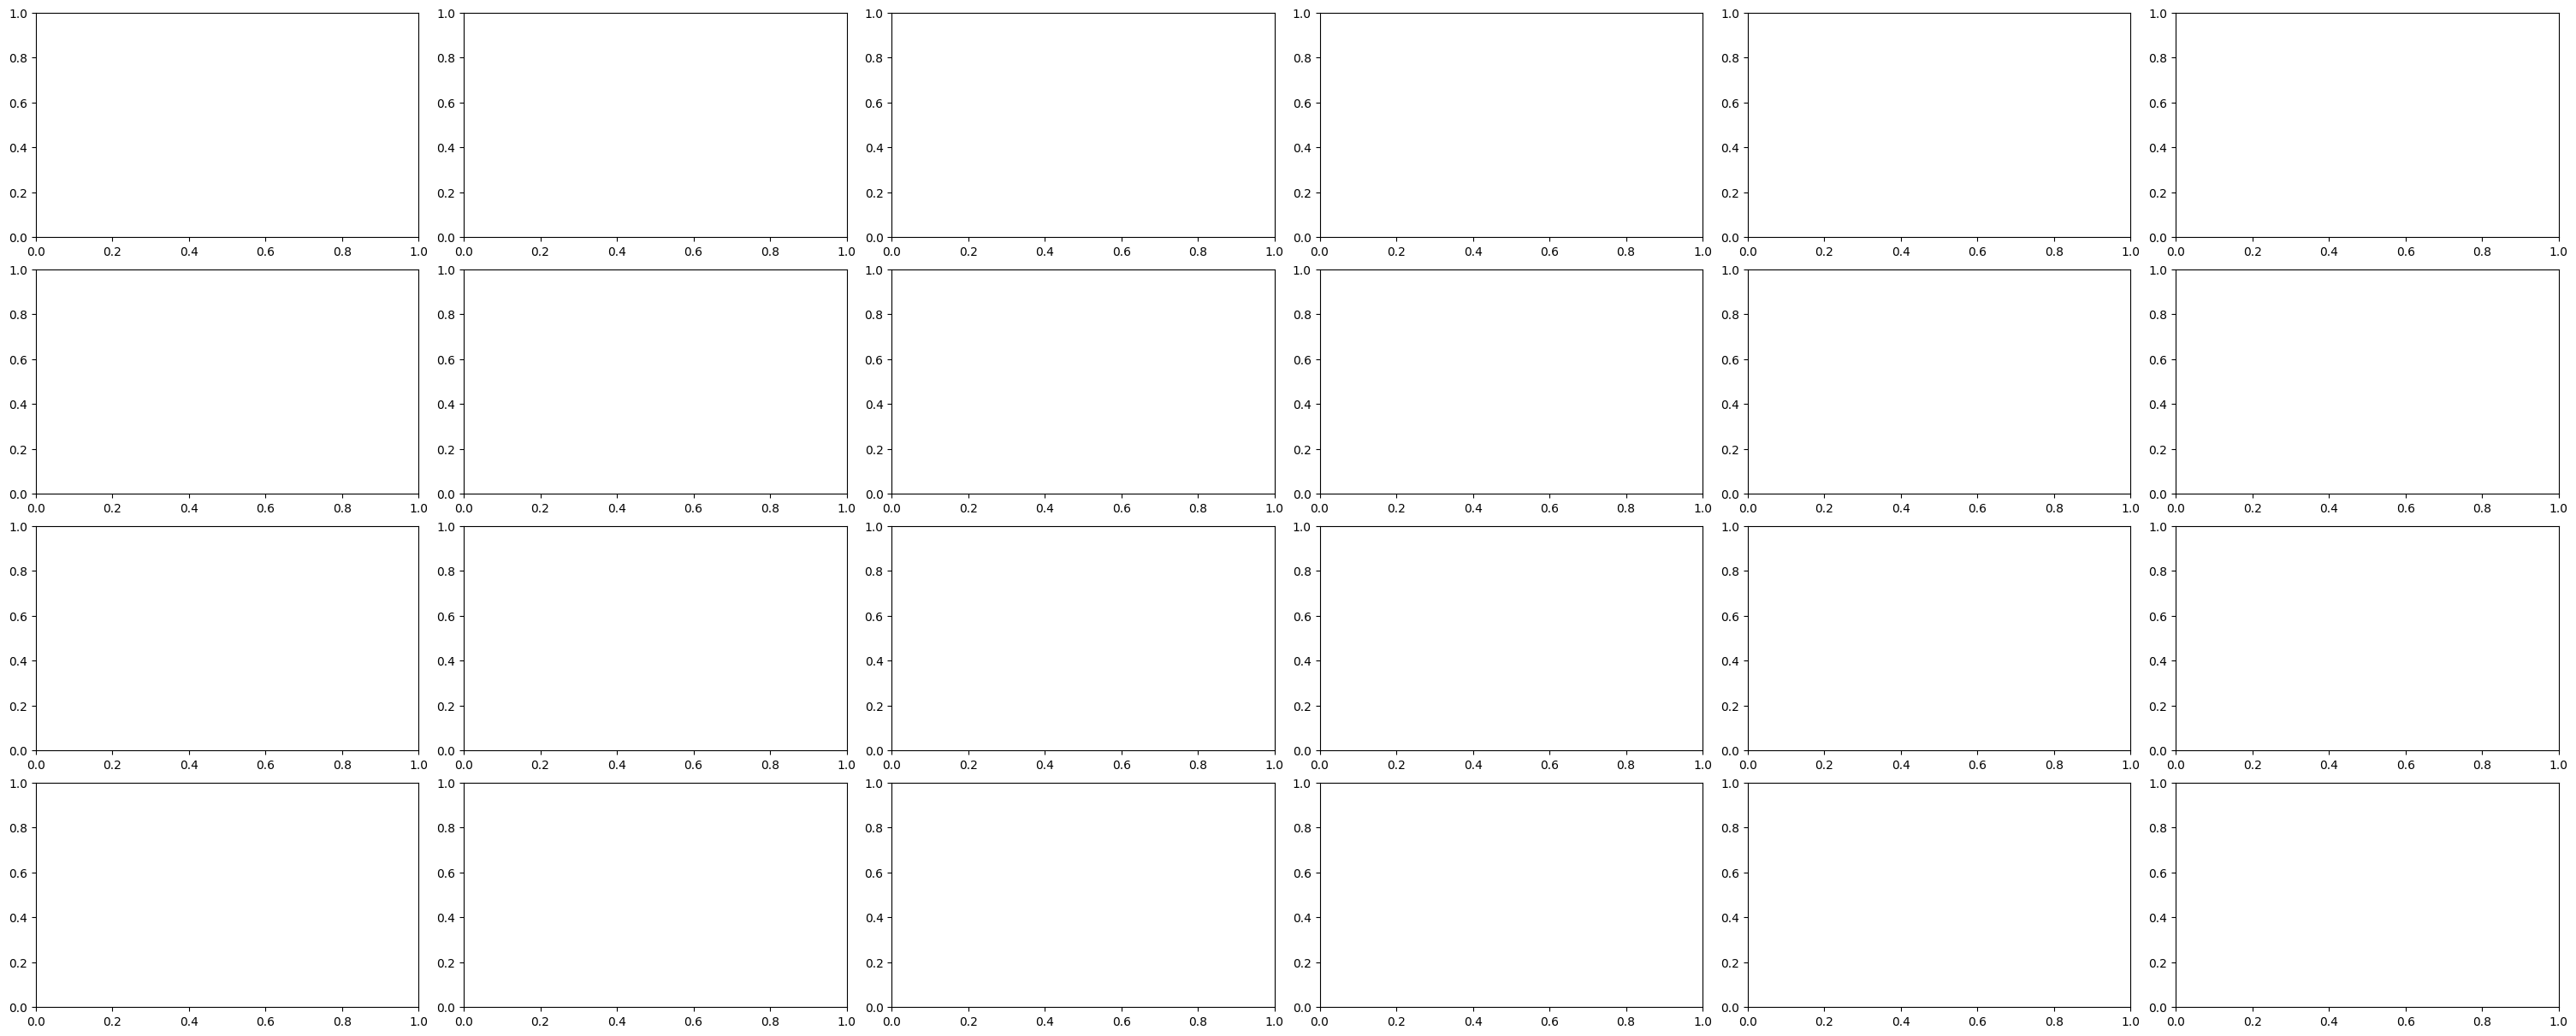

In [ ]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)
